In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import os


plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.1)
pd.set_option('display.max_columns', None)

df = pd.read_csv("../data/listings_sample.csv")

## EDA

### 1. Schema & quality

In [3]:
print("✅ the fundamental information for this dataset:")
display(df.info())
display(df.head())

print("\n✅ missing value:")
display(df.isnull().sum())

print("\n✅ the fundamental information for the numerical columns:")
numeric_cols = ['price', 'beds', 'baths', 'sqft']
df[numeric_cols].describe().T

✅ the fundamental information for this dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          160 non-null    object
 1   address     160 non-null    object
 2   city        160 non-null    object
 3   state       160 non-null    object
 4   price       160 non-null    int64 
 5   beds        160 non-null    int64 
 6   baths       160 non-null    int64 
 7   sqft        160 non-null    int64 
 8   remarks     160 non-null    object
 9   agent_id    160 non-null    object
 10  list_date   160 non-null    object
 11  media_urls  160 non-null    object
dtypes: int64(4), object(8)
memory usage: 15.1+ KB


None

,id,address,city,state,price,beds,baths,sqft,remarks,agent_id,list_date,media_urls
0,MLS-TX-1000,"960 Cedar Ct, Frisco, TX",Frisco,TX,803788,3,3,3892,"quiet cul-de-sac, two-car garage, near good sc...",AG7396,2025-07-14,"[""https://picsum.photos/seed/0/1200/800""]"
1,MLS-CA-1001,"2658 Elm Dr, Santa Clara, CA",Santa Clara,CA,1908765,3,2,3547,"fresh paint, new roof 2022, large backyard, HO...",AG3612,2024-12-05,"[""https://picsum.photos/seed/1/1200/800""]"
2,MLS-CA-1002,"7199 Birch Way, Mountain View, CA",Mountain View,CA,507705,4,3,1575,"updated kitchen, stainless appliances, fresh p...",AG1995,2024-09-26,"[""https://picsum.photos/seed/2/1200/800""]"
3,MLS-TX-1003,"7729 Walnut Blvd, Frisco, TX",Frisco,TX,1016982,4,1,3143,"granite counters, new roof 2022, tile flooring...",AG6892,2025-05-04,"[""https://picsum.photos/seed/3/1200/800""]"
4,MLS-TX-1004,"6284 Oak Ave, Frisco, TX",Frisco,TX,682810,4,1,2663,"two-car garage, hardwood floors, vaulted ceili...",AG6977,2025-07-07,"[""https://picsum.photos/seed/4/1200/800""]"



✅ missing value:


id            0
address       0
city          0
state         0
price         0
beds          0
baths         0
sqft          0
remarks       0
agent_id      0
list_date     0
media_urls    0
dtype: int64


✅ the fundamental information for the numerical columns:


,count,mean,std,min,25%,50%,75%,max
price,160.0,1.101729e+06,787928.163629,175142.0,508517.50,863020.5,1454584.25,3528809.0
beds,160.0,3.456250e+00,0.983172,2.0,3.00,3.0,4.00,5.0
baths,160.0,2.156250e+00,0.687232,1.0,2.00,2.0,3.00,3.0
sqft,160.0,2.380988e+03,985.057563,809.0,1479.75,2399.0,3158.25,4187.0


### 2. Univariate distributions

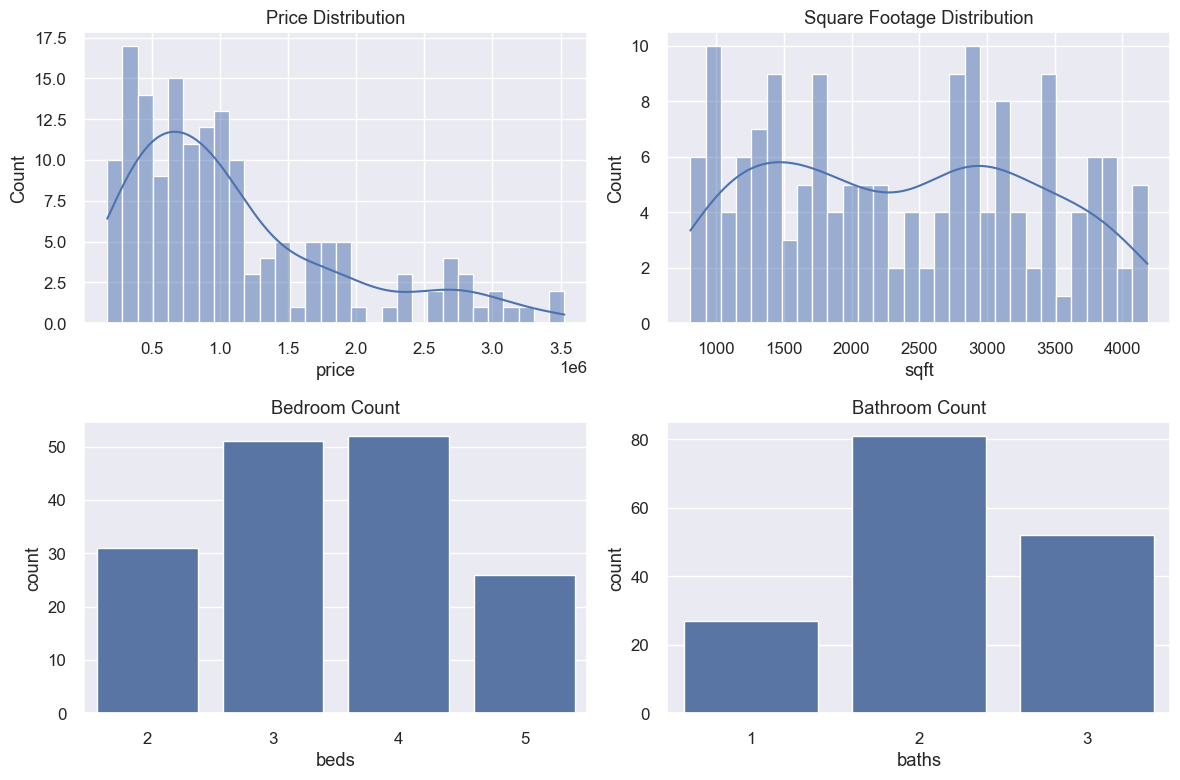

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['price'], bins=30, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Price Distribution')

sns.histplot(df['sqft'], bins=30, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Square Footage Distribution')

sns.countplot(x='beds', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Bedroom Count')

sns.countplot(x='baths', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Bathroom Count')

plt.tight_layout()
plt.show()

### 3. Key derived metric

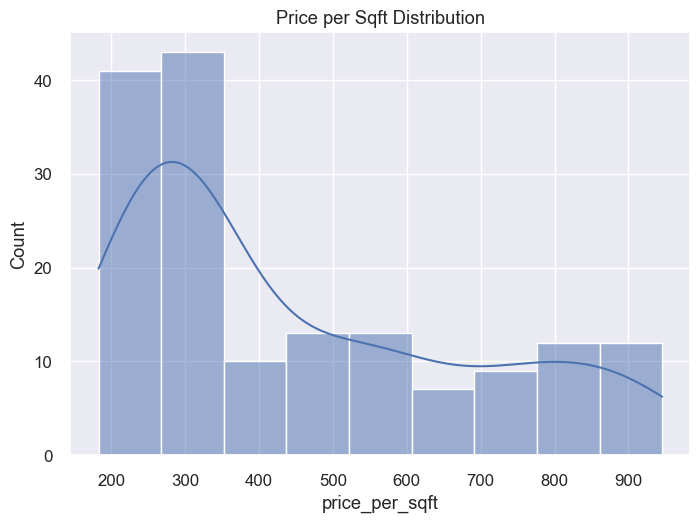

In [5]:
df['price_per_sqft'] = df['price'] / df['sqft']
sns.histplot(df['price_per_sqft'], kde=True)
plt.title("Price per Sqft Distribution")
plt.show()

### 4. City-wise variation

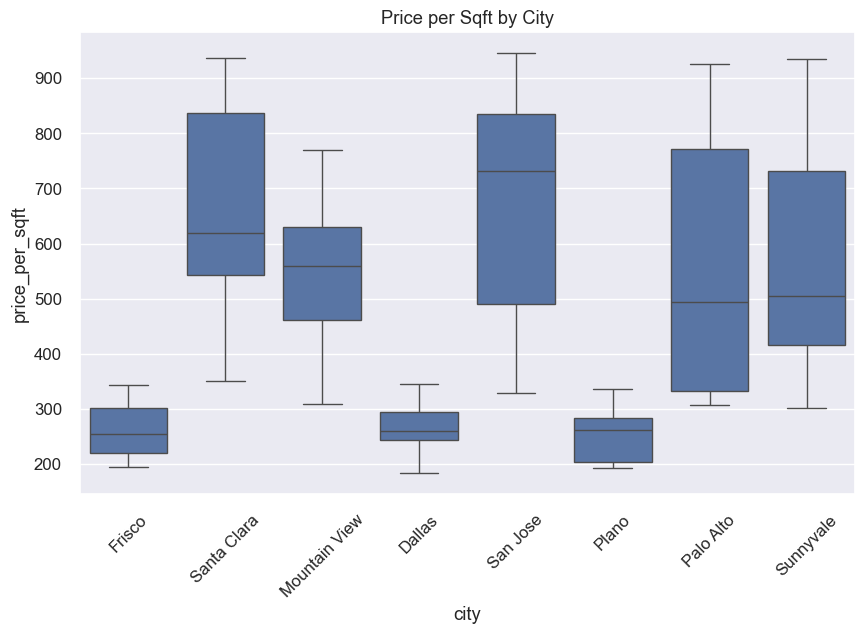

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='city', y='price_per_sqft', data=df)
plt.title('Price per Sqft by City')
plt.xticks(rotation=45)
plt.show()


### 5. Correlations

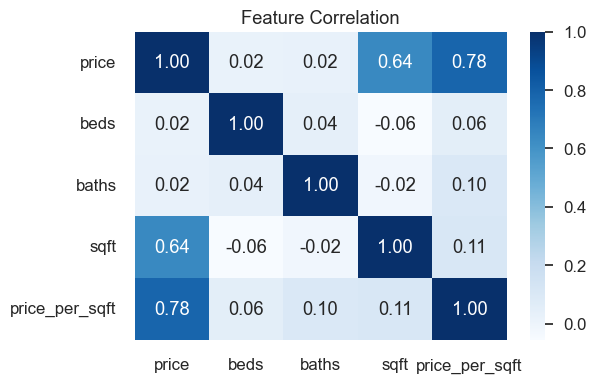

In [7]:
corr = df[['price', 'beds', 'baths', 'sqft', 'price_per_sqft']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title("Feature Correlation")
plt.show()

### 6. Text signals

In [8]:
keywords = ['pool', 'garage', 'quiet', 'updated', 'backyard']
for kw in keywords:
    count = df['remarks'].str.contains(kw, case=False, na=False).sum()
    print(f"{kw:>10}: {count} listings")

      pool: 36 listings
    garage: 37 listings
     quiet: 51 listings
   updated: 32 listings
  backyard: 43 listings


In [9]:
city_stats = (
    df.groupby('city')[['price', 'sqft', 'price_per_sqft']]
    .agg(['mean', 'median', 'count'])
    .round(2)
)
display(city_stats)

price                      sqft                \
                     mean     median count     mean  median count   
city                                                                
Dallas          568650.77   528357.0    22  2174.73  2307.5    22   
Frisco          607010.08   583510.0    26  2341.62  2320.0    26   
Mountain View  1195256.47   963112.0    17  2085.00  1820.0    17   
Palo Alto      1284737.33   945974.0    18  2206.61  2004.0    18   
Plano           607718.19   683476.0    21  2381.10  2424.0    21   
San Jose       1609787.57  1338572.0    21  2527.33  2628.0    21   
Santa Clara    1790246.28  1661489.0    18  2672.89  2966.5    18   
Sunnyvale      1514550.76  1680137.0    17  2698.76  2851.0    17   

              price_per_sqft                
                        mean  median count  
city                                        
Dallas                263.99  259.73    22  
Frisco                257.86  254.70    26  
Mountain View         538.85  558.44    17  
Palo Alto             548.29  493.01    18  
Plano                 252.86  261.61    21  
San Jose              669.60  730.98    21  
Santa Clara           664.95  619.60    18  
Sunnyvale             556.25  505.16    17

### Key Conclusions
* Data integrity: 160 records, 12 columns; no missing values. Safe to proceed to modeling/analysis.
* Distributions (price, sqft): Both are right-skewed with long tails. Prefer median/IQR or log transforms for robust analysis.

### Price per Sqft
* Stability: price_per_sqft = price / sqft is more comparable across cities than total price, but still somewhat right-skewed.
* Outliers: Use IQR to flag unusually high/low pps to identify luxury/repair-needed cases or potential data issues.

### City differences
* Use medians: City-level comparisons should prioritize median price_per_sqft to reflect typical market levels.

### Correlation structure
* Price vs. Sqft: Strong positive correlation—size is the primary price driver.
* Beds/Baths: Correlated with both price and sqft, implying multicollinearity; apply feature selection or regularization.
* pps vs. Sqft: Often negative—larger homes tend to have slightly lower unit prices.

### Text signals
* Keyword frequencies: quiet (51) ≈ backyard (43) > garage (37) ≈ pool (36) > updated (32).
* Interpretation: “quiet” and “backyard” are common (weaker differentiation); “pool”, “garage”, “updated” may carry stronger price signals. Consider binary features and test their marginal impact on pps.


## Feature Engineering

In [10]:
# Feature Engineering: keyword flags from remarks
keywords = ['pool', 'garage', 'quiet', 'updated', 'backyard']
for kw in keywords:
    col = f"has_{kw}"
    df[col] = df['remarks'].str.contains(kw, case=False, na=False).astype(int)

print("Added keyword flags:", [f"has_{k}" for k in keywords])


Added keyword flags: ['has_pool', 'has_garage', 'has_quiet', 'has_updated', 'has_backyard']


In [11]:
# Feature Engineering: structural ratios and date parts
# Guard against division by zero
safe_beds = df['beds'].replace(0, np.nan)
safe_baths = df['baths'].replace(0, np.nan)

# Structural ratios
df['sqft_per_bed'] = (df['sqft'] / safe_beds).replace([np.inf, -np.inf], np.nan)
df['baths_per_bed'] = (df['baths'] / safe_beds).replace([np.inf, -np.inf], np.nan)
df['beds_per_bath'] = (df['beds'] / safe_baths).replace([np.inf, -np.inf], np.nan)

# Date parts
# Ensure list_date is parsed to datetime
if df['list_date'].dtype == 'O':
    df['list_date'] = pd.to_datetime(df['list_date'], errors='coerce')

df['list_year'] = df['list_date'].dt.year
df['list_month'] = df['list_date'].dt.month

df[['sqft_per_bed', 'baths_per_bed', 'beds_per_bath', 'list_year', 'list_month']].head()


,sqft_per_bed,baths_per_bed,beds_per_bath,list_year,list_month
0,1297.333333,1.000000,1.000000,2025,7
1,1182.333333,0.666667,1.500000,2024,12
2,393.750000,0.750000,1.333333,2024,9
3,785.750000,0.250000,4.000000,2025,5
4,665.750000,0.250000,4.000000,2025,7


In [12]:
# Feature Engineering: log transforms
# Add small epsilon to avoid log(0) if any
EPS = 1e-6

df['log_price'] = np.log(df['price'] + EPS)
df['log_sqft'] = np.log(df['sqft'] + EPS)
if 'price_per_sqft' not in df:
    df['price_per_sqft'] = df['price'] / df['sqft']
df['log_pps'] = np.log(df['price_per_sqft'] + EPS)

print("Added logs: log_price, log_sqft, log_pps")


Added logs: log_price, log_sqft, log_pps


In [13]:
# City-level aggregates and outlier flags (based on pps)
city_agg = (
    df.groupby('city')['price_per_sqft']
      .agg(city_pps_median='median', city_pps_mean='mean', city_count='count')
      .reset_index()
)

df = df.merge(city_agg, on='city', how='left')

# Outliers using overall IQR on pps
pps_q1 = df['price_per_sqft'].quantile(0.25)
pps_q3 = df['price_per_sqft'].quantile(0.75)
pps_iqr = pps_q3 - pps_q1
low_thr = pps_q1 - 1.5 * pps_iqr
high_thr = pps_q3 + 1.5 * pps_iqr

df['is_pps_outlier_low'] = (df['price_per_sqft'] < low_thr).astype(int)
df['is_pps_outlier_high'] = (df['price_per_sqft'] > high_thr).astype(int)

print("City aggregates joined; outlier flags added.")


City aggregates joined; outlier flags added.


In [14]:
# Quick summary of engineered features
summary_cols = [
    'price', 'sqft', 'price_per_sqft', 'log_price', 'log_sqft', 'log_pps',
    'beds', 'baths', 'sqft_per_bed', 'baths_per_bed', 'beds_per_bath',
    'list_year', 'list_month',
    'has_pool', 'has_garage', 'is_quiet', 'is_updated', 'has_backyard',
    'city_pps_median', 'city_pps_mean', 'city_count',
    'is_pps_outlier_low', 'is_pps_outlier_high'
]

# Some keywords might be missing if remarks never contained them; fill safely
available_cols = [c for c in summary_cols if c in df.columns]

print(f"Displaying first 5 rows for {len(available_cols)} engineered columns:")
df[available_cols].head()


Displaying first 5 rows for 21 engineered columns:


,price,sqft,price_per_sqft,log_price,log_sqft,log_pps,beds,baths,sqft_per_bed,baths_per_bed,beds_per_bath,list_year,list_month,has_pool,has_garage,has_backyard,city_pps_median,city_pps_mean,city_count,is_pps_outlier_low,is_pps_outlier_high
0,803788,3892,206.523124,13.597091,8.266678,5.330412,3,3,1297.333333,1.000000,1.000000,2025,7,1,1,0,254.701998,257.860153,26,0,0
1,1908765,3547,538.135044,14.461967,8.173857,6.288110,3,2,1182.333333,0.666667,1.500000,2024,12,1,0,1,619.599589,664.954186,18,0,0
2,507705,1575,322.352381,13.137656,7.362011,5.775645,4,3,393.750000,0.750000,1.333333,2024,9,0,0,0,558.436014,538.854966,17,0,0
3,1016982,3143,323.570474,13.832350,8.052933,5.779417,4,1,785.750000,0.250000,4.000000,2025,5,0,0,0,254.701998,257.860153,26,0,0
4,682810,2663,256.406309,13.433972,7.887209,5.546763,4,1,665.750000,0.250000,4.000000,2025,7,0,1,0,254.701998,257.860153,26,0,0


## Model Train

In [15]:
# Target: price_per_sqft
model_df = df.copy()
model_df = model_df.dropna(subset=['price_per_sqft', 'sqft', 'beds', 'baths', 'city'])

numeric_features = [
    'sqft', 'beds', 'baths', 'sqft_per_bed', 'baths_per_bed', 'beds_per_bath',
    'log_sqft', 'city_pps_median'
]
keyword_features = [c for c in ['has_pool','has_garage','is_quiet','is_updated','has_backyard'] if c in model_df.columns]

categorical_features = ['city']

X = model_df[numeric_features + keyword_features + categorical_features]
y = model_df['price_per_sqft']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=True, with_std=True), numeric_features + keyword_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='drop'
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (128, 12), Test size: (32, 12)


In [16]:
reg_models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
}

reg_results = {}
for name, mdl in reg_models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', mdl)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    reg_results[name] = {
        'MAE': mean_absolute_error(y_test, pred),
        'RMSE': mean_squared_error(y_test, pred),
        'R2': r2_score(y_test, pred),
        'model': pipe
    }

print("Regression results (pps):")
for k, v in reg_results.items():
    print(f"{k:>22} | MAE: {v['MAE']:.1f} | RMSE: {v['RMSE']:.1f} | R2: {v['R2']:.3f}")

best_reg = max(reg_results, key=lambda k: reg_results[k]['R2'])
print(f"Best regression model: {best_reg}")


Regression results (pps):
      LinearRegression | MAE: 111.4 | RMSE: 22746.9 | R2: 0.584
 RandomForestRegressor | MAE: 107.9 | RMSE: 21361.2 | R2: 0.610
Best regression model: RandomForestRegressor


In [17]:
q_low, q_high = y_train.quantile([0.33, 0.66])

def to_band(v):
    if v <= q_low:
        return 'low'
    elif v <= q_high:
        return 'med'
    else:
        return 'high'

y_train_band = y_train.apply(to_band)
y_test_band = y_test.apply(to_band)

clf_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
}

for name, mdl in clf_models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', mdl)])
    pipe.fit(X_train, y_train_band)
    pred = pipe.predict(X_test)
    print(f"\n{name} classification report:\n", classification_report(y_test_band, pred, digits=3))
    print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test_band, pred))



LogisticRegression classification report:
               precision    recall  f1-score   support

        high      0.667     0.800     0.727        10
         low      0.875     0.933     0.903        15
         med      0.250     0.143     0.182         7

    accuracy                          0.719        32
   macro avg      0.597     0.625     0.604        32
weighted avg      0.673     0.719     0.690        32

Confusion matrix (rows=true, cols=pred):
 [[ 8  0  2]
 [ 0 14  1]
 [ 4  2  1]]


/Users/althealam/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/althealam/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/althealam/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/althealam/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/Users/althealam/Library/Python/3.9/lib/python/site-packages/sklearn/linear_mo


RandomForestClassifier classification report:
               precision    recall  f1-score   support

        high      0.750     0.900     0.818        10
         low      0.867     0.867     0.867        15
         med      0.600     0.429     0.500         7

    accuracy                          0.781        32
   macro avg      0.739     0.732     0.728        32
weighted avg      0.772     0.781     0.771        32

Confusion matrix (rows=true, cols=pred):
 [[ 9  0  1]
 [ 1 13  1]
 [ 2  2  3]]


## LLM Integration

### 1. RAG: build corpus and embeddings (TF-IDF fallback)


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

remarks = df['remarks'].fillna("").tolist()
ids = df['id'].tolist()

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(remarks)

# Retriever using cosine similarity
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(X_tfidf)

print("TF-IDF index built for remarks. n=", len(remarks))

TF-IDF index built for remarks. n= 160


### 2. RAG Q&A function with rule-based generation fallback


In [19]:
def retrieve_context(question, top_k=3):
    q_vec = vectorizer.transform([question])
    distances, indices = nn.kneighbors(q_vec, n_neighbors=top_k)
    ctx = []
    for idx in indices[0]:
        ctx.append({
            'id': ids[idx],
            'remarks': remarks[idx]
        })
    return ctx


def answer_question(question, top_k=3):
    ctx = retrieve_context(question, top_k=top_k)
    snippets = " \n\n".join([c['remarks'] for c in ctx])
    q_lower = question.lower()
    heuristics = []
    if 'pool' in q_lower:
        has = any('pool' in c['remarks'].lower() for c in ctx)
        heuristics.append(f"Pool mentioned: {'yes' if has else 'no'}.")
    if 'garage' in q_lower:
        has = any('garage' in c['remarks'].lower() for c in ctx)
        heuristics.append(f"Garage mentioned: {'yes' if has else 'no'}.")
    
    answer = "Here is what I found from similar listings: "
    if heuristics:
        answer += " ".join(heuristics)
    else:
        # Fallback: short generic synthesis
        answer += "Listings emphasize features like updated interiors, quiet streets, and backyards."
    return answer, ctx

print("RAG Q&A ready. Use answer_question('your query').")


RAG Q&A ready. Use answer_question('your query').


In [20]:
ans, ctx = answer_question("Do these listings typically have a pool?", top_k=3)
print(ans)
print("\nTop contexts:")
for c in ctx:
    print(f"- {c['id']}: {c['remarks'][:120]}...")


Here is what I found from similar listings: Pool mentioned: yes.

Top contexts:
- MLS-TX-1063: large backyard, EV charger, granite counters, HOA includes pool...
- MLS-TX-1008: HOA includes pool, corner lot, tile flooring, EV charger...
- MLS-CA-1083: near good schools, stainless appliances, primary suite, HOA includes pool...


In [ ]:
# Export figures for results/one_pager.tex
os.makedirs('../results', exist_ok=True)

# Ensure target exists
if 'price_per_sqft' not in df.columns:
    df['price_per_sqft'] = df['price'] / df['sqft']

# 1) Price distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.tight_layout()
plt.savefig('../results/fig_price_dist.png', dpi=200)
plt.close()

# 2) Sqft distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['sqft'], bins=30, kde=True)
plt.title('Sqft Distribution')
plt.tight_layout()
plt.savefig('../results/fig_sqft_dist.png', dpi=200)
plt.close()

# 3) Price per sqft by city (boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(x='city', y='price_per_sqft', data=df)
plt.title('Price per Sqft by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../results/fig_pps_by_city.png', dpi=200)
plt.close()

# 4) Correlation heatmap
corr = df[['price', 'beds', 'baths', 'sqft', 'price_per_sqft']].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
plt.title('Feature Correlation')
plt.tight_layout()
plt.savefig('../results/fig_corr_heatmap.png', dpi=200)
plt.close()

print('Saved to results/: fig_price_dist.png, fig_sqft_dist.png, fig_pps_by_city.png, fig_corr_heatmap.png')


Saved to results/: fig_price_dist.png, fig_sqft_dist.png, fig_pps_by_city.png, fig_corr_heatmap.png
